In [93]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.preprocessing import StandardScaler

# Loading results dataframes for use in linear regression modeling
run_data = pd.read_csv("data/stream-data/raw-stream-data/russian.csv", thousands=',')
days_below_32 = pd.read_csv("data/weather-data/KenaiAirport_Days-Below-32F.csv")
summer_mean_temps = pd.read_csv("data/weather-data/KenaiAirport_Summer-Mean-Temps-Yearly.csv")
winter_mean_temps = pd.read_csv("data/weather-data/KenaiAirport_Winter-Mean-Temps-Yearly.csv")
stream_flow_soldotna = pd.read_csv("data/stream-data/streamflow-Soldotna.csv")
stream_flow_cooper = pd.read_csv("data/stream-data/streamflow-CooperLanding.csv")

# merge the temperature data into a single dataframe
input_data = pd.merge(left=days_below_32, right=summer_mean_temps, left_on='year', right_on='year')
input_data = pd.merge(left=input_data, right=winter_mean_temps, left_on='year', right_on='year')
# adding missing years and imputing their values at the mean
missing_days = pd.DataFrame({
    'year' : [1970, 1971, 1972],
    'days_below_32' : [None, None, None],
    'mean_summer_temp' : [None, None, None],
    'mean_winter_temp' : [None, None, None]
})
input_data = pd.concat([input_data, missing_days])
imputer = SimpleImputer(strategy='mean')
x_vals = imputer.fit_transform(input_data)
input_data = pd.DataFrame(x_vals, columns=input_data.columns)
# sorting the data by year for readability/plotting purposes
input_data.sort_values(by=['year'], inplace=True, ignore_index=True)

Now that we have our data loaded and the proper modules imported, let's process the Russian
River run datafile to parse out our target output variables (run counts) as well as gather a 
few more potential input variables (effort counts or "angler days").

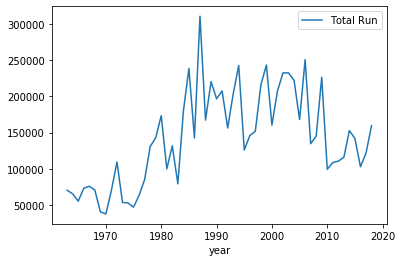

In [94]:
drop_columns = ['ER  Escapement', 'LR Escapement', 'ER', 'LR']
run_data.drop(columns=drop_columns, inplace=True)
run_data.rename(columns={'Year' : 'year'}, inplace=True)
# merge with the input_data frame
model_data = pd.merge(left=input_data, right=run_data, left_on='year', right_on='year')
# dropping the year with no Effort value
model_data.drop(index=0, inplace=True)
model_data['Effort'] = model_data['Effort'].str.replace(',', '').astype(int)

# plotting total run per year to see how the data trends by itself
model_data.plot(x='year', y='Total Run')

Now we need to timelag the Effort column for 3 years prior (average life of salmon before returning).
This allows the effort values of prior years to be used as a predictor for future runs.

In [95]:
def get_effort_3_years_ago(row):
    target_year = row.year - 3
    try:
        return model_data[model_data['year'] == target_year].iloc[0]['Effort']
    except:
        return None

temp_data = model_data.drop(index=[1,2,3])
temp_data['effort_3_years_ago'] = temp_data.apply(get_effort_3_years_ago, axis=1)
model_data = temp_data

# merging in streamflow data
model_data = pd.merge(left=model_data, right=stream_flow_soldotna, left_on='year', right_on='year')
model_data = pd.merge(left=model_data, right=stream_flow_cooper, left_on='year', right_on='year')
model_data.drop(['Unnamed: 0_x', 'date_x', 'Unnamed: 0_y', 'date_y'], axis=1, inplace=True)
model_data.rename(columns={
                    'CFS_x' : 'cfs_soldotna',
                    'CFS_y' : 'cfs_cooper',
                    'gage_height_x': 'gage_height_soldotna',
                    'gage_height_y': 'gage_height_cooper'}, inplace=True)
# imputing missing values
imputer = SimpleImputer(strategy='mean')
x_vals = imputer.fit_transform(model_data)
model_data = pd.DataFrame(x_vals, columns=model_data.columns)

Let's take a look at the correlations between our dataset to see if we can identify any
potential collinearity that will allow us to simply our input complexity.

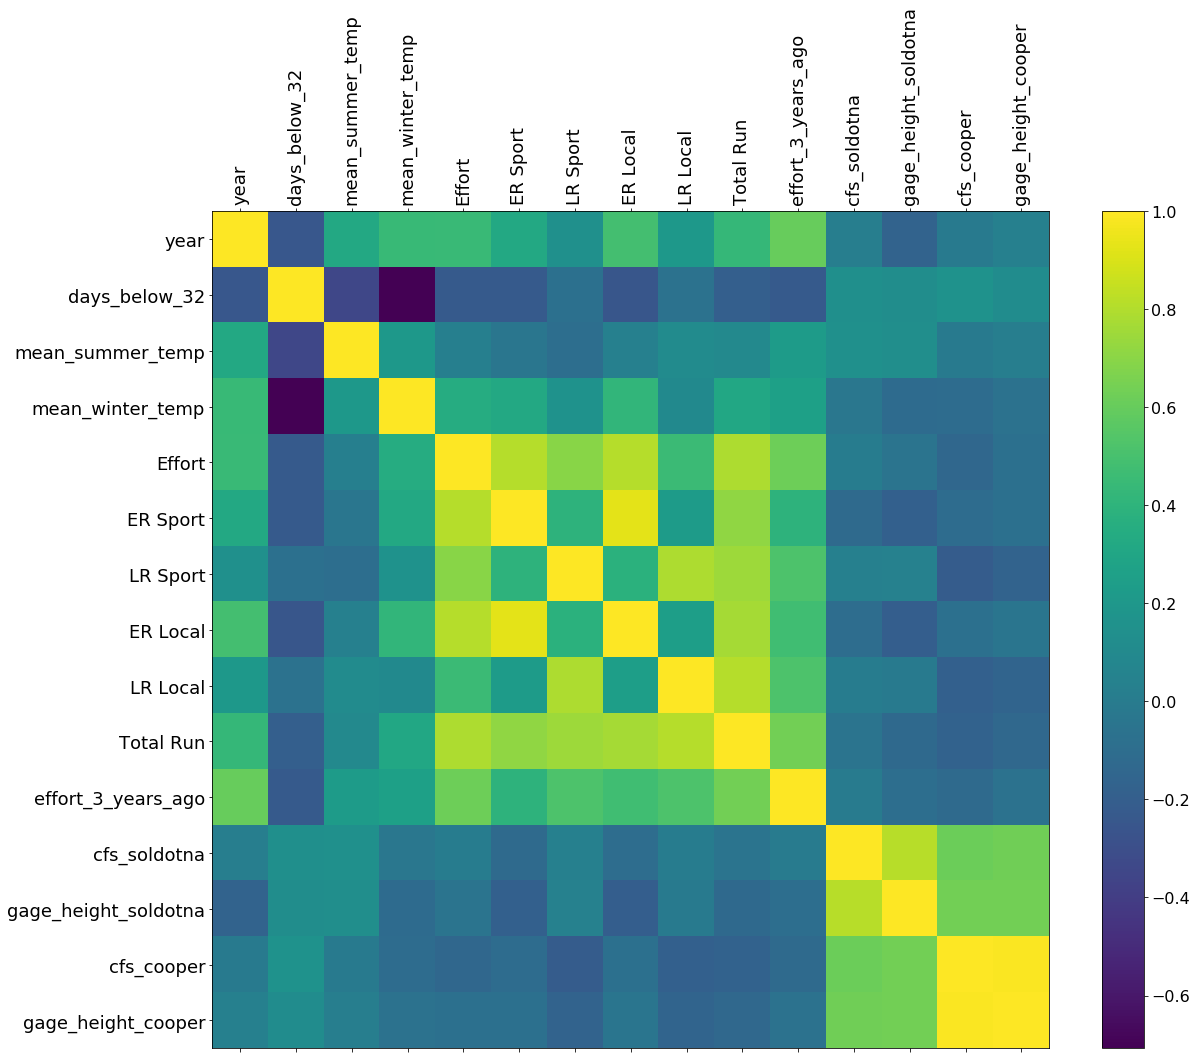

In [96]:
matrix = model_data.corr()
correlations = plt.figure(figsize=(19,15))
plt.matshow(matrix, fignum=correlations.number)
plt.xticks(range(model_data.shape[1]), model_data.columns, rotation=90, fontsize=18)
plt.yticks(range(model_data.shape[1]), model_data.columns, fontsize=18)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=16)

Now it's time to try and train the model using basic linear regression as well as Lasso and Ridge
regression techniques to see how capable our data is at predicting run counts.

In [ ]:
# splitting the dataframe into x and y values
#   x values - should be everything except year and Total Run
#   y values - total run counts
x = model_data.drop(['year', 'Total Run', 'ER Local', 'LR Local', 'cfs_cooper', 'gage_height_cooper'], axis=1)
y = model_data.loc[:, 'Total Run']

# looping 10000 times for generating mean R^2 value
total_train_scores = 0
total_test_scores = 0
for i in range(10000):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
    
    # setting up the linear regression model
    linear_model = LinearRegression()
    linear_model.fit(x_train, y_train)
    total_train_scores += linear_model.score(x_train, y_train)
    total_test_scores += linear_model.score(x_test, y_test)
    

print("Mean Training R^2: {}".format(total_train_scores / 10000))
print("Mean Test R^2: {}".format(total_test_scores / 10000))

In [ ]:
coefficients = pd.concat([pd.DataFrame(x.columns), pd.DataFrame(np.transpose(linear_model.coef_))], axis=1)
coefficients.columns = ["Feature", "Coefficient"]
coefficients

Now let's try modeling with Ridge and Lasso regression to see if normalizing the coefficients improves our
prediction accuracy.

In [ ]:
# first we need to standardize the feature inputs so they're within a similar range
scaler = StandardScaler()
x_std = scaler.fit_transform(x)
# make the Ridge and Lasso cross-validated models
alphas = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

# looping 10000 times to get an average
ridge_train_score_total = 0
ridge_test_score_total = 0
lasso_train_score_total = 0
lasso_test_score_total = 0
for i in range(10000):
    ridge_cv = RidgeCV(alphas=alphas)
    lasso_cv = LassoCV(alphas=alphas)
    x_train, x_test, y_train, y_test = train_test_split(x_std, y, test_size=0.3)
    # fitting the models to the training data
    ridge_cv.fit(x_train, y_train)
    lasso_cv.fit(x_train, y_train)
    ridge_train_score_total += ridge_cv.score(x_train, y_train)
    ridge_test_score_total += ridge_cv.score(x_test, y_test)
    lasso_train_score_total += lasso_cv.score(x_train,y_train)
    lasso_test_score_total += lasso_cv.score(x_test, y_test)
print("Ridge Mean Training R^2: {}".format(ridge_train_score_total / 10000))
print("Ridge Mean Test R^2: {}".format(ridge_test_score_total / 10000))
print("Lasso Mean Training R^2: {}".format(lasso_train_score_total / 10000))
print("Lasso Mean Test R^2: {}".format(lasso_test_score_total / 10000))